In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1443416580091660585
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9658631357036114075
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2):
    return compare_ssim(img1, img2)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [4]:
"""
    load validation data
"""
import gc

dataY = np.zeros((100,512, 512))

for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[i-1] = img
    
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [5]:
"""
    noise 50%
"""
X_50 = np.zeros((100,512, 512))
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + "_noise50.png", cv2.IMREAD_GRAYSCALE)
    X_50[i-1] = img

X_50 = X_50.reshape(-1, 512, 512, 1)
X_50 = X_50.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_50 ==
loss: 0.0010052966512739659
accuracy: 0.0


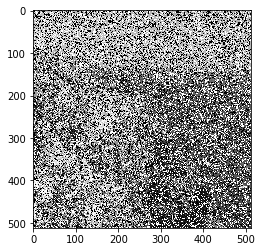

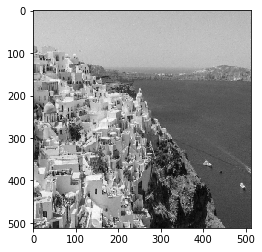

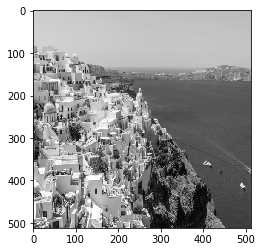

29.79241371154785
29.977052211761475
0.9866761401377064


In [32]:
model = SRCNN("SRCNN_500099.h5")
print("== SRCNN_50 ==")
X_50 = X_50.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_50, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_50)
result = result.reshape(-1, 512, 512)
X_50 = X_50.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_50[22]
plt.imshow(img, cmap="gray")
plt.show()

img = result[22]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[22]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[22], result[22]) )
print(PSNR(dataY, result) )
print(SSIM(dataY, result))

In [7]:
"""
    noise 60%
"""
X_60 = np.zeros((100,512, 512))
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + "_noise60.png", cv2.IMREAD_GRAYSCALE)
    X_60[i-1] = img

X_60 = X_60.reshape(-1, 512, 512, 1)
X_60 = X_60.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_60 ==
loss: 0.0014540843479335307
accuracy: 0.0


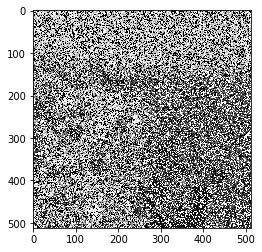

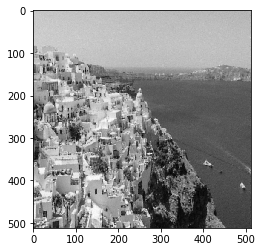

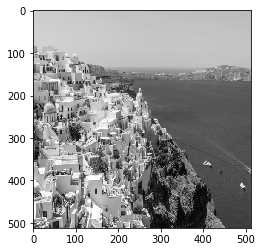

28.147287368774414
28.374104499816895
0.9806426438030582


In [33]:
model = SRCNN("SRCNN_600099.h5")
print("== SRCNN_60 ==")
X_60 = X_60.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_60, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_60)
result = result.reshape(-1, 512, 512)
X_60 = X_60.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_60[22]
plt.imshow(img, cmap="gray")
plt.show()

img = result[22]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[22]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[22], result[22]) )
print(PSNR(dataY, result) )
print(SSIM(dataY, result))

In [10]:
"""
    noise 70%
"""
X_70 = np.zeros((100,512, 512))
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + "_noise70.png", cv2.IMREAD_GRAYSCALE)
    X_70[i-1] = img

X_70 = X_70.reshape(-1, 512, 512, 1)
X_70 = X_70.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_70 ==
loss: 0.0022926022112369536
accuracy: 0.0


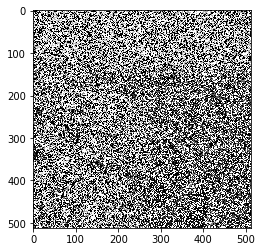

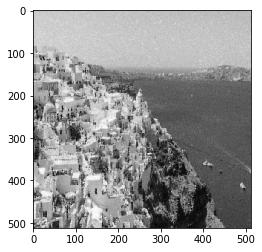

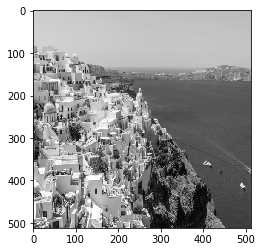

26.18173837661743
26.39671564102173
0.969445990970359


In [34]:
model = SRCNN("SRCNN_700095.h5")
print("== SRCNN_70 ==")
X_70 = X_70.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_70, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_70)
result = result.reshape(-1, 512, 512)
X_70 = X_70.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_70[22]
plt.imshow(img, cmap="gray")
plt.show()

img = result[22]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[22]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[22], result[22]) )
print(PSNR(dataY, result) )
print(SSIM(dataY, result))

In [12]:
"""
    noise 80%
"""
X_80 = np.zeros((100,512, 512))
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + "_noise80.png", cv2.IMREAD_GRAYSCALE)
    X_80[i-1] = img

X_80 = X_80.reshape(-1, 512, 512, 1)
X_80 = X_80.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_80 ==
loss: 0.0031088124215602874
accuracy: 0.0


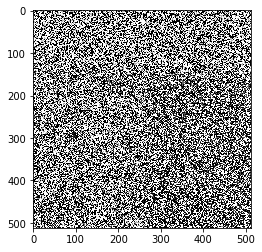

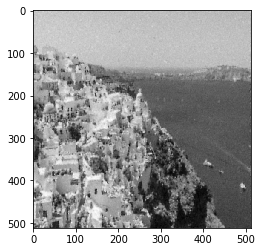

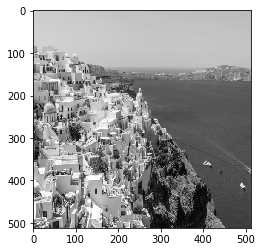

24.9783992767334
25.074052810668945
0.9580094322869441


In [35]:
model = SRCNN("SRCNN_800093.h5")
print("== SRCNN_80 ==")
X_80 = X_80.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_80, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_80)
result = result.reshape(-1, 512, 512)
X_80 = X_80.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_80[22]
plt.imshow(img, cmap="gray")
plt.show()

img = result[22]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[22]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[22], result[22]) )
print(PSNR(dataY, result) )
print(SSIM(dataY, result))

In [14]:
"""
    noise 90%
"""
X_90 = np.zeros((100,512, 512))
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + "_noise90.png", cv2.IMREAD_GRAYSCALE)
    X_90[i-1] = img

X_90 = X_90.reshape(-1, 512, 512, 1)
X_90 = X_90.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_90 ==
loss: 0.005428827963769436
accuracy: 0.0


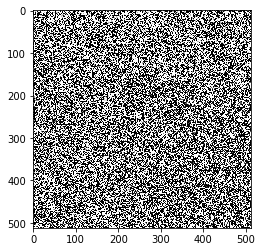

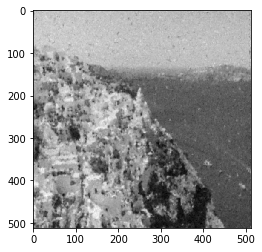

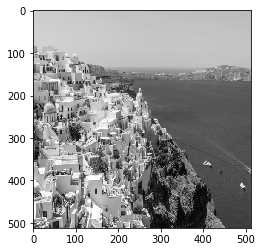

22.746155261993408
22.65294313430786
0.927146392162314


In [36]:
model = SRCNN("SRCNN_900095.h5")
print("== SRCNN_90 ==")
X_90 = X_90.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_90, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_90)
result = result.reshape(-1, 512, 512)
X_90 = X_90.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_90[22]
plt.imshow(img, cmap="gray")
plt.show()

img = result[22]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[22]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[22], result[22]) )
print(PSNR(dataY, result) )
print(SSIM(dataY, result))